In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, printDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleRegular, emitParticlesRegular, emitParticlesSDF
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.sphOps import sphOperationFluidState
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.plotting import scatterPlotFluid, scatterPlotFluidSymmetric, plotImplicitSDF
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorField, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco
from diffSPH.v2.modules.surfaceDetection import computeSurfaceDistance, getStableSurfaceNormal
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

In [2]:
from diffSPH.v2.plotting import *
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from diffSPH.v2.noise import generateNoise

# *grid, noiseSimplex = generateNoise(n = 128, baseFrequency= 3, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=True, kind = 'simplex')
# fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
# xx, yy = [g.detach().cpu().numpy() for g in grid]
# axis[0,0].pcolormesh(xx, yy, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
# for xoffset in [-1,0,1]:
#     for yoffset in [-1,0,1]:
#         axis[0,1].pcolormesh(xx + xoffset * 2, yy + yoffset * 2, noiseSimplex.detach().cpu().numpy(), cmap = 'viridis')
# fig.tight_layout()

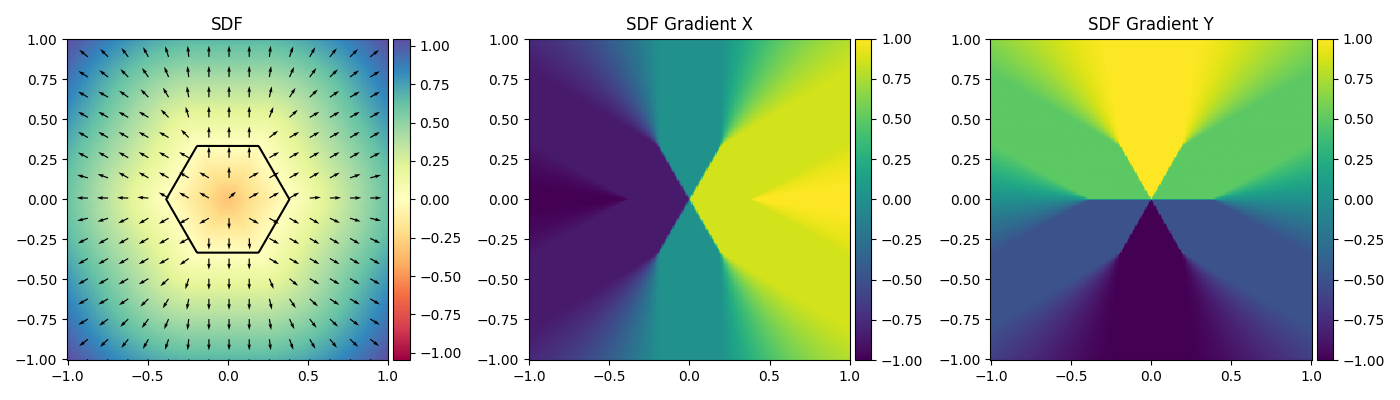

In [3]:


ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 1/3)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
plotSDF(sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

In [84]:
config = {
    # 'domain': {
    #     'minExtent': -1,
    #     'maxExtent': 1,
    #     'dim': 2,
    #     'periodic': True
    # },
    'particle': {
        'nx': 300
    },
    'compute':{
        'device': 'cuda'
    },
    # 'kernel':{
    #     'name': 'Wendland2',
    #     'targetNeighbors': 45.22,
    # },
    "neighborhood":{
        "scheme": "compact"
    },
    # 'EOS':{
    #     'type': 'Tait',
    #     'kappa': 1.5
    # },
    'fluid':{
        'cs' : 18.75
    },
    'shifting':{
        'scheme': 'deltaSPH',
        'maxIterations': 1,
        'freeSurface': True
    },
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

print(config['particle']['support'] / ( 2 * config['particle']['dx']))

L = 2/3
# config['particle']['dx'] = (L) / (config['particle']['nx'] + 1)
# config['particle']['volume'] = config['particle']['dx']**config['domain']['dim']


(L - config['particle']['dx']) // config['particle']['dx']
display(config)

# L - dx = nx * dx
# L = (nx + 1) * dx
# dx = L / (nx + 1)

tensor(1.8974, device='cuda:0')


{'particle': {'nx': 300,
  'dx': tensor(0.0067, device='cuda:0'),
  'support': tensor(0.0253, device='cuda:0'),
  'defaultVolume': tensor(4.4444e-05, device='cuda:0'),
  'defaultSupport': tensor(0.0253, device='cuda:0'),
  'volume': tensor(4.4444e-05, device='cuda:0'),
  'smoothingLength': tensor(0.0133, device='cuda:0')},
 'compute': {'device': 'cuda', 'precision': 'float32', 'dtype': torch.float32},
 'neighborhood': {'scheme': 'compact', 'verletScale': 1.5},
 'fluid': {'cs': 18.75, 'rho0': 1000, 'mu': 0.1},
 'shifting': {'scheme': 'deltaSPH',
  'maxIterations': 1,
  'freeSurface': True,
  'R': 0.25,
  'n': 4,
  'CFL': 1.5,
  'computeMach': True,
  'solver': 'BiCGStab_wJacobi',
  'normalScheme': 'lambda',
  'projectionScheme': 'mat',
  'threshold': 0.01,
  'surfaceScaling': 0.1,
  'summationDensity': False,
  'useExtendedMask': False,
  'initialization': 'zero',
  'maxSolveIter': 64,
  'surfaceDetection': 'Barcasco',
  'active': True},
 'domain': {'minExtent': tensor([-1., -1.], devic

In [85]:
# from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
# from diffSPH.v2.sampling import filterParticlesWithSDF

# particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
# particlesA = particlesA.to(config['compute']['device'])
# volumeA = volumeA.to(config['compute']['device'])

# # areasA = particlesA.new_ones(particlesA.shape[0]) * volumeA
# # onesA = particlesA.new_ones(particlesA.shape[0])
# # supportsA = particlesA.new_ones(particlesA.shape[0]) * h

# factor = 1
# # particlesB, volumeB = sampleRegular(dx / factor, dim, minExtent, domainMax, targetNeighbors, True, k)
# # hB = volumeToSupport(volumeB, targetNeighbors, dim)
# # areasB = particlesB.new_ones(particlesB.shape[0]) * volumeA
# # onesB = particlesB.new_ones(particlesB.shape[0])
# # supportsB = particlesB.new_ones(particlesB.shape[0]) * h
# h = volumeToSupport(volumeA, config['kernel']['targetNeighbors'], config['domain']['dim'])

# maskedA, maskA, sdfValues, sdfGradients = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)

In [86]:
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
# scatterPlotSymmetric(fig, axis[0,0], particlesA, sdfValues, config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
# scatterPlotSymmetric(fig, axis[0,1], particlesA, sdfGradients[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
# scatterPlotSymmetric(fig, axis[0,2], particlesA, sdfGradients[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8)

# fig.tight_layout()

In [87]:
# nx = config['particle']['nx']
# *grid, noiseSimplex = generateNoise(n = nx, baseFrequency= 3, dim = 2, octaves = 1, persistence = 0.5, lacunarity = 2.0, seed = 23467586, tileable=True, kind = 'simplex')

# print(noiseSimplex.shape)
# fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
# scatterPlotSymmetric(fig, axis[0,0], particlesA, noiseSimplex.flatten(), config['domain']['minExtent'], config['domain']['maxExtent'], 'noise field', cmap = 'twilight_r', s = 8)
# for offset in [[-1,-1], [0,-1], [1,-1], [-1,0], [0,0], [1,0], [-1,1], [0,1], [1,1]]:
#     axis[0,1].scatter(particlesA[:,0].detach().cpu().numpy() + offset[0] * 2, particlesA[:,1].detach().cpu().numpy() + offset[1] * 2, c = noiseSimplex.detach().cpu().flatten(), cmap = 'twilight_r', s = 1)
# fig.tight_layout()

In [88]:
# noiseConfig = {
#     'n': nx,
#     'baseFrequency': 3,
#     'dim': 2,
#     'octaves': 1,
#     'persistence': 0.5,
#     'lacunarity': 2.0,
#     'seed': 23467586,
#     'tileable': True,
#     'kind': 'simplex'
# }


In [89]:
from diffSPH.v2.sampling import sampleNoisyParticles, sampleParticles

In [90]:
config['particle']['dx'] = torch.tensor(config['particle']['dx'], device = config['compute']['device'])
config['particle']['volume'] = torch.tensor(config['particle']['dx']**2, device = config['compute']['device'])
print(config['particle'])

{'nx': 300, 'dx': tensor(0.0067, device='cuda:0'), 'support': tensor(0.0253, device='cuda:0'), 'defaultVolume': tensor(4.4444e-05, device='cuda:0'), 'defaultSupport': tensor(0.0253, device='cuda:0'), 'volume': tensor(4.4444e-05, device='cuda:0'), 'smoothingLength': tensor(0.0133, device='cuda:0')}


In [91]:
particleState, mask = sampleParticles(config, sdfs = [sphere_b])

# for k in particleState.keys():
#     if isinstance(particleState[k], torch.Tensor):
#         particleState[k] = particleState[k][mask]
# particleState['numParticles'] = particleState['fluidPositions'].shape[0]
# # noiseState['fluidVelocities'], noiseState['fluidDivergence'] = sampleVelocityField(noiseState)
# del particleState['fluidNeighborhood']
# particleState['fluidNeighborhood'] = fluidNeighborSearch(particleState, config)
# particleState['fluidDensities'] = sphOperationFluidState(particleState, None, 'density')
# _, particleState['fluidNumNeighbors'] = countUniqueEntries(particleState['fluidNeighborhood']['indices'][0], particleState['fluidPositions'])

# particleState['fluidIndex'] = torch.arange(particleState['numParticles'], device = config['compute']['device'])

particleState['numParticles']

10000

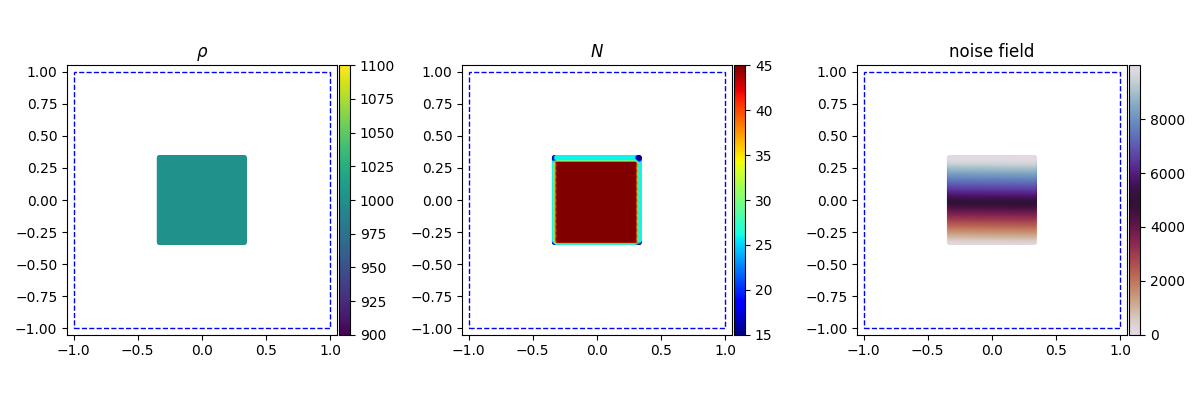

In [92]:


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particleState['fluidPositions'], particleState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluidPositions'], particleState['fluidNumNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluidPositions'], particleState['fluidIndex'], config['domain']['minExtent'], config['domain']['maxExtent'], 'noise field', cmap = 'twilight_r', s = 8)

fig.tight_layout()

In [93]:
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationFluidState
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
import copy

# perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)
# gradRho = sphOperationFluidState(perennialState, (perennialState['fluidDensities'], perennialState['fluidDensities']), operation = 'gradient', gradientMode='difference')
# perennialState['fluidGradRho^L'] = renormalizedDensityGradient(perennialState, config)
# densityDiffusion = computeDensityDeltaTerm(perennialState, config)


In [94]:
config['EOS']['type'] = 'isoThermal'

In [95]:
perennialState = copy.deepcopy(particleState)
perennialState['fluidDensities'][:] = config['fluid']['rho0']

# perennialState['fluidVelocities'][:,1] = 0
# perennialState['fluidVelocities'][perennialState['fluidPositions'][:,1] < 0,0] = 1
# perennialState['fluidVelocities'][perennialState['fluidPositions'][:,1] > 0,0] = -1

In [96]:
config['domain']['periodicity']

tensor([False, False], device='cuda:0')

In [97]:
from diffSPH.v2.math import mod
def gravity(fluidState, config):
    x = fluidState['fluidPositions']
    minD = config['domain']['minExtent']
    maxD = config['domain']['maxExtent']
    periodicity = config['domain']['periodicity']

    xij = torch.stack([x[:,i] if not periodic_i else mod(x[:,i], minD[i], maxD[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)
    rij = torch.linalg.norm(xij, dim = -1)
    xij[rij > 1e-7] = xij[rij > 1e-7] / rij[rij > 1e-7, None]

    magnitude = 2.0
    return -0.5 * magnitude**2 * xij * (rij)[:,None]**2

In [98]:
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne


def simulationStepNoDiffusion(simulationState, config):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
    simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
    simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
    simulationState['fluidGradRho'] = sphOperationFluidState(simulationState, (perennialState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    # simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
    simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)


    simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
    simulationState['fluidFreeSurface'], cA, cB = detectFreeSurfaceMaronne(simulationState, config)
    (i,j) = simulationState['fluidNeighborhood']['indices']
    numParticles = simulationState['numParticles']
    simulationState['fluidFreeSurface'] = detectFreeSurfaceBarecasco(particleState, config)
                
    simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)

    # simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)
    simulationState['fluidPressures'] = computeEOS(simulationState, config)
    simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
    # simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)
    simulationState['fluidDivergence'] = sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')

    simulationState['fluidGravityAccel'] = gravity(simulationState, config) * 0

    dudt = simulationState['fluidPressureAccel'] + simulationState['fluidGravityAccel']
    drhodt = simulationState['fluidMomentumEquation']
    return simulationState['fluidVelocities'].clone(), dudt, drhodt


In [99]:
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne


def simulationStepDiffusion(simulationState, config):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
    simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
    simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
    simulationState['fluidGradRho'] = sphOperationFluidState(simulationState, (simulationState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
    simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)


    simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
    simulationState['fluidFreeSurface'], cA, cB = detectFreeSurfaceMaronne(simulationState, config)
    (i,j) = simulationState['fluidNeighborhood']['indices']
    numParticles = simulationState['numParticles']
    simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)

    simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)
    simulationState['fluidPressures'] = computeEOS(simulationState, config)
    simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
    simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)
    simulationState['fluidDivergence'] = sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')

    simulationState['fluidGravityAccel'] = gravity(simulationState, config) * 0

    dudt = simulationState['fluidVelocityDiffusion']
    drhodt = simulationState['fluidDensityDiffusion']
    return simulationState['fluidVelocities'].clone(), dudt, drhodt

def simulationStep(simulationState, config):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
    simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
    simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
    simulationState['fluidGradRho'] = sphOperationFluidState(simulationState, (simulationState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
    simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)


    simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
    simulationState['fluidFreeSurface'], cA, cB = detectFreeSurfaceMaronne(simulationState, config)
    (i,j) = simulationState['fluidNeighborhood']['indices']
    numParticles = simulationState['numParticles']
    simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)

    simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)
    simulationState['fluidPressures'] = computeEOS(simulationState, config)
    simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
    simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)
    simulationState['fluidDivergence'] = sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')

    simulationState['fluidGravityAccel'] = gravity(simulationState, config) * 0

    dudt = simulationState['fluidPressureAccel'] + simulationState['fluidGravityAccel']
    drhodt = simulationState['fluidMomentumEquation']
    dudt += simulationState['fluidVelocityDiffusion']
    drhodt += simulationState['fluidDensityDiffusion']
    return simulationState['fluidVelocities'].clone(), dudt, drhodt


In [100]:
display(config['diffusion'])

{'delta': 0.1,
 'densityScheme': 'deltaSPH',
 'velocityScheme': 'deltaSPH_inviscid',
 'nu': 0.01,
 'alpha': 0.01,
 'beta': 0.0,
 'pi-switch': False,
 'artificial-constant': 0.02,
 'eps': 1e-06}

In [101]:
# config['timestep']['dt'] = 0.001
# config['integration']['scheme'] = 'RK4'
# config['diffusion']['velocityScheme'] = 'deltaSPH'
# config['shifting']['initialization'] = 'zero'
# config['shifting']['scheme'] = 'IPS'
# config['shifting']['scheme'] = 'deltaSPH'
# config['shifting']['threshold'] = 0.05
# config['shifting']['maxIterations'] = 0
# config['shifting']['solver'] = 'BiCGStab_wJacobi'
# config['shifting']['freeSurface'] = True
# config['shifting']['useExtendedMask'] = False
# config['shifting']['projectionScheme'] = 'mat'
# config['shifting']['surfaceScaling'] = 1.0
# config['shifting']['surfaceDetection'] = 'colorGrad'
# config['surfaceDetection']['expansionIterations'] = 2
# config['shifting']['surfaceDetection'] = 'Maronne'
# config['shifting']['surfaceDetection'] = 'Barcasco'
# config['shifting']['initialization'] = 'deltaMinus'

display(config['diffusion'])


# config['shifting']['initialization'] = 'zero'
# config['shifting']['scheme'] = 'IPS'
# config['shifting']['scheme'] = 'deltaSPH'
# config['shifting']['threshold'] = 0.025
# config['shifting']['maxIterations'] = 1
# config['shifting']['solver'] = 'BiCGStab_wJacobi'
# config['shifting']['freeSurface'] = True
# config['shifting']['useExtendedMask'] = False
# config['shifting']['projectionScheme'] = 'mat'
# config['shifting']['surfaceScaling'] = 1.0
# config['shifting']['surfaceDetection'] = 'colorGrad'
# config['surfaceDetection']['expansionIterations'] = 2
# config['shifting']['surfaceDetection'] = 'Barcasco'
# config['shifting']['computeMach'] = True
# config['shifting']['summationDensity'] = False
# config['diffusion']['alpha'] = 0.01
# config['timestep']['dt'] = 0.0005

{'delta': 0.1,
 'densityScheme': 'deltaSPH',
 'velocityScheme': 'deltaSPH_inviscid',
 'nu': 0.01,
 'alpha': 0.01,
 'beta': 0.0,
 'pi-switch': False,
 'artificial-constant': 0.02,
 'eps': 1e-06}

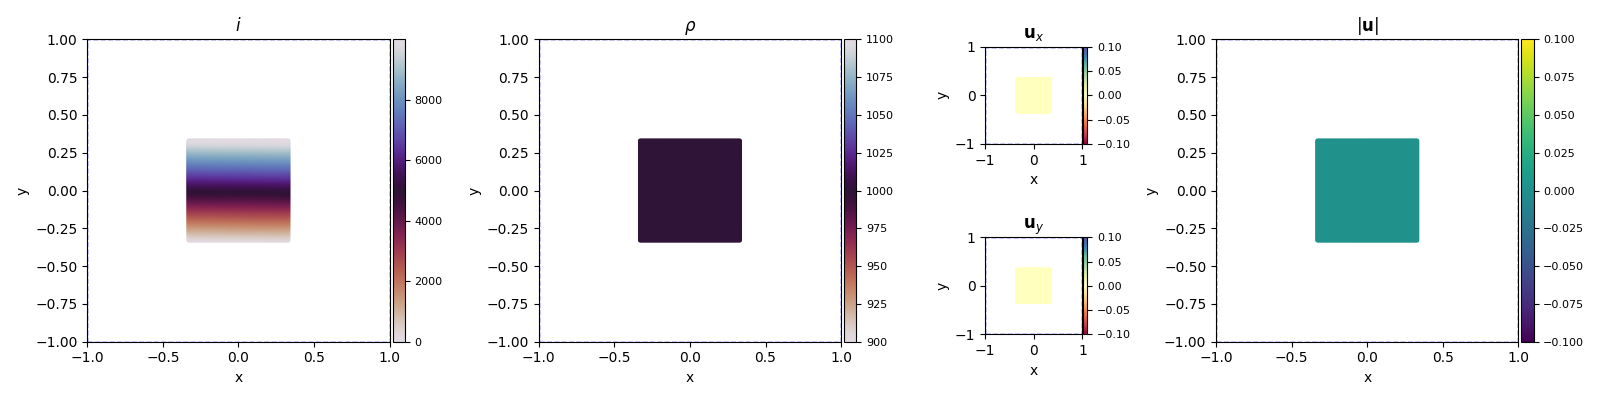

In [102]:
s = 8

fig, axis = plt.subplot_mosaic('''AAEEBCC
                               AAEEDCC''', figsize=(16,4), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)

plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidIndex'], cbar = True, cmap = 'twilight_r', scaling = 'lin', midPoint = 0, gridVisualization= False)
axis['A'].set_title('$i$')
plotStateDensity = visualizeParticles(fig, axis['E'], config, visualizationState, perennialState['fluidDensities'], cbar = True, cmap = 'twilight_r', scaling = 'sym', midPoint = config['fluid']['rho0'], gridVisualization= False)
axis['E'].set_title('$\\rho$')
plotStateA = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.x', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= False)
axis['B'].set_title('$\\mathbf{u}_x$')
plotStateB = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.y', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= False)
axis['D'].set_title('$\\mathbf{u}_y$')
plotStateVelocityNorm = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidVelocities'], mapping = 'L2', cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False)
axis['C'].set_title('$|\\mathbf{u}|$')
fig.tight_layout()


In [127]:
perennialState = copy.deepcopy(particleState)
# newState = {}
# for k in perennialState.keys():
#     if k in ['fluidPositions', 'fluidDensities', 'fluidAreas', 'fluidMasses', 'fluidSupports', 'fluidVelocities', 'fluidIndex', 'fluidIndex', 'numParticles']:
#         newState[k] = perennialState[k]
# perennialState = newState

priorState = None
config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
config['diffusion']['nu'] = 0.1

perennialState['fluidDensities'][:] = config['fluid']['rho0']
# perennialState['fluidSupports'][:] = config['particle']['dx'] * 2
# config['particle']['support'] = config['particle']['dx'] * 2
# config['particle']['defaultSupport'] = config['particle']['dx'] * 2

omega = 4
perennialState['fluidVelocities'][:,0] =  omega * perennialState['fluidPositions'][:,1]
perennialState['fluidVelocities'][:,1] = -omega * perennialState['fluidPositions'][:,0]

perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
perennialState['fluidDivergence'] = computeMomentumEquation(perennialState, config)

In [128]:
# config['shifting']['scheme'] = 'deltaSPH'
# config['shifting']['maxIterations'] = 1
# config['shifting']['freeSurface'] = True

In [129]:
# config['shifting']['initialization'] = 'zero'
# config['shifting']['scheme'] = 'IPS'
# config['shifting']['scheme'] = 'deltaSPH'
# config['shifting']['threshold'] = 0.01
# config['shifting']['maxIterations'] = 1
# config['shifting']['solver'] = 'BiCGStab_wJacobi'
# config['shifting']['freeSurface'] = True
# config['shifting']['useExtendedMask'] = False
# config['shifting']['projectionScheme'] = 'mat'
# config['shifting']['surfaceScaling'] = 0.1
# config['shifting']['surfaceDetection'] = 'colorGrad'
# config['surfaceDetection']['expansionIterations'] = 2
# config['shifting']['surfaceDetection'] = 'Maronne'
# config['shifting']['surfaceDetection'] = 'Barcasco'
# config['shifting']['computeMach'] = True
# config['shifting']['summationDensity'] = False
# config['diffusion']['alpha'] = 0.01
# config['timestep']['dt'] = 0.001
# config['integration']['scheme'] = 'RK4'
# config['diffusion']['delta'] = 0.1
# config['diffusion']['nu'] = 0.01
# config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
# config['diffusion']['pi-switch'] = False

In [130]:
display(config['EOS'])
# config['fluid']['cs'] = 18.75

{'gasConstant': 8.14,
 'molarMass': 0.02897,
 'polytropicExponent': 7,
 'kappa': 1.3,
 'type': 'isoThermal'}

In [131]:
printState(perennialState)

state[numParticles            ]:      10000	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:        0.0	[<class 'float'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -3.314e-01, max: +3.314e-01, median: -1.925e-03 [torch.Size([10000, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +4.444e-05, max: +4.444e-05, median: +4.444e-05 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: -6.373e+00, max: -2.618e+00, median: -6.373e+00 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: -3.404e+01, max: -8.917e+00, median: -3.403e+01 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +4.444e-02, max: +4.444e-02, median: +4.444e-02 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +2.530e-02, max: +2.530e-02, median: +2.530e-

In [132]:
torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1))

tensor(1.8668, device='cuda:0')

In [133]:
display(perennialState['fluidNeighborhood']['indices'][0].shape )
display(perennialState['fluidNeighborhood']['fullIndices'][0].shape )

torch.Size([435708])

torch.Size([962120])

In [134]:
perennialState['fluidNeighborhood']['supports']

tensor([0.0253, 0.0253, 0.0253,  ..., 0.0253, 0.0253, 0.0253], device='cuda:0')

In [135]:
config['particle']['support']

tensor(0.0253, device='cuda:0')

In [136]:
perennialState['fluidNeighborhood']['distances'].max()
# config['neighborhood']['verletScale']

tensor(0.9502, device='cuda:0')

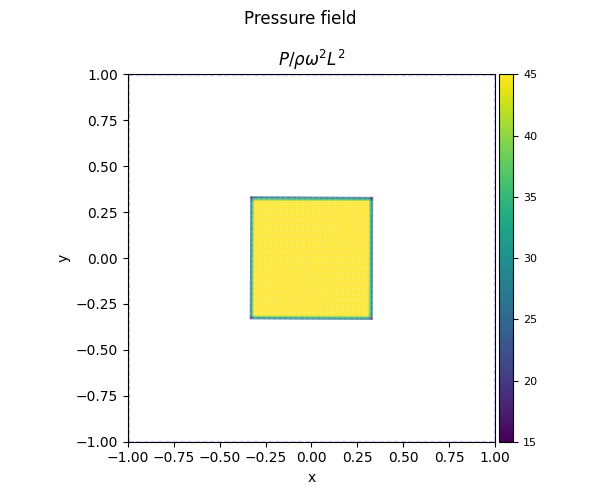

In [137]:
s = 8

fig, axis = plt.subplot_mosaic('''A''', figsize=(6,5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)

perennialState['fluidPressures'] = computeEOS(perennialState, config)
val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# perennialState['fluidSupports'][:] = config['particle']['dx'] * 2

# del perennialState['fluidNeighborhood']

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
_, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])

plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidNumNeighbors'], cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
axis['A'].set_title(r'$P/\rho\omega^2L^2$')
fig.suptitle('Pressure field')
fig.tight_layout()


In [144]:
from diffSPH.v2.util import printState
printState(perennialState)

state[numParticles            ]:      10000	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:        0.0	[<class 'float'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -9.012e-01, max: +9.012e-01, median: -5.559e-05 [torch.Size([10000, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +4.444e-05, max: +4.444e-05, median: +4.444e-05 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: -4.721e+02, max: +2.039e+02, median: -5.995e+01 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: -1.754e+02, max: +1.729e+02, median: +2.351e-01 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +4.444e-02, max: +4.444e-02, median: +4.444e-02 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +2.530e-02, max: +2.530e-02, median: +2.530e-

RuntimeError: Sort currently does not support bool dtype on CUDA.

In [139]:
display(config)

{'particle': {'nx': 300,
  'dx': tensor(0.0067, device='cuda:0'),
  'support': tensor(0.0253, device='cuda:0'),
  'defaultVolume': tensor(4.4444e-05, device='cuda:0'),
  'defaultSupport': tensor(0.0253, device='cuda:0'),
  'volume': tensor(4.4444e-05, device='cuda:0'),
  'smoothingLength': tensor(0.0133, device='cuda:0')},
 'compute': {'device': 'cuda', 'precision': 'float32', 'dtype': torch.float32},
 'neighborhood': {'scheme': 'compact', 'verletScale': 1.5},
 'fluid': {'cs': 18.75, 'rho0': 1000, 'mu': 0.1},
 'shifting': {'scheme': 'deltaSPH',
  'maxIterations': 1,
  'freeSurface': True,
  'R': 0.25,
  'n': 4,
  'CFL': 1.5,
  'computeMach': True,
  'solver': 'BiCGStab_wJacobi',
  'normalScheme': 'lambda',
  'projectionScheme': 'mat',
  'threshold': 0.01,
  'surfaceScaling': 0.1,
  'summationDensity': False,
  'useExtendedMask': False,
  'initialization': 'zero',
  'maxSolveIter': 64,
  'surfaceDetection': 'Barcasco',
  'active': True},
 'domain': {'minExtent': tensor([-1., -1.], devic

In [140]:
time = 0.0
frame = 0
nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
nu = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu
dt_v = 0.125 * config['particle']['support']**2 / nu / config['kernel']['kernelScale']**2
dt_c = 1.5 * config['particle']['support'] / config['fluid']['cs'] / config['kernel']['kernelScale']
print(dt_v, dt_c)



tensor(0.0375, device='cuda:0') tensor(0.0011, device='cuda:0')


In [141]:
h = torch.tensor(config['particle']['support'])
dx = torch.tensor(config['particle']['dx'])

Wdx = config['kernel']['function'].kernel(dx / h * config['kernel']['kernelScale'], h)
W0 = config['kernel']['function'].kernel(torch.tensor(0.0), h)
print(f'W(dx) = {Wdx}, W(0) = {W0}')
print(f'Ratio: {W0 / Wdx}')
print(f'Error: {5.3 / (W0 / Wdx)}')

W(dx) = 652.7833862304688, W(0) = 3481.512939453125
Ratio: 5.333335876464844
Error: 0.9937495589256287


In [142]:
config['kernel']

{'name': 'Wendland2',
 'targetNeighbors': tensor(45.2390, device='cuda:0'),
 'function': <diffSPH.kernels.KernelWrapper at 0x7fabc085e150>,
 'kernelScale': tensor(1.8974, device='cuda:0')}

In [143]:
from tqdm.autonotebook import tqdm
from diffSPH.v2.modules.shifting import solveShifting

import os
import datetime

# timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
# outFolder = './output/' + timestamp + '/'
# os.makedirs(outFolder, exist_ok = True)

    
for i in tqdm(range(10 * 510)):
    perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # dxdt, dudt, drhodt = simulationStepDiffusion(perennialState, config)

    # perennialState['fluidDensities'] += config['timestep']['dt'] * drhodt
    # perennialState['fluidVelocities'] += config['timestep']['dt'] * dudt

    time = time + config['timestep']['dt']
    if time > 2.0:
        break

    dx, _ = solveShifting(perennialState, config)
    perennialState['fluidPositions'] += dx 

    dudt = priorState[2]  #+ dudt

    max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
    dt_a = 0.25 * torch.sqrt(config['particle']['support'] / (max_accel + 1e-7)) / config['kernel']['kernelScale']


    dt = min(dt_v, dt_a, dt_c) 

    fig.suptitle(rf'''Frame {i}, Time {time:.3f}, $\delta x = {torch.max(torch.linalg.norm(dx, dim=-1)) / config["particle"]["support"]:.3e}$
$\Delta t = {config["timestep"]["dt"]:.3e}$, new $\Delta t = {dt:.3e}$''')
    config['timestep']['dt'] = dt
    # dxdt, dudt, drhodt = simulationStepDiffusion(perennialState, config)

    # perennialState['fluidDensities'] += config['timestep']['dt'] * drhodt
    # perennialState['fluidVelocities'] += config['timestep']['dt'] * dudt
    frame = frame + 1
    if i % 16 == 0 and i > 0:
        perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
        _, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])
        perennialState['fluidPressures'] = computeEOS(perennialState, config)
        val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
        visualizationState = prepVisualizationState(perennialState, config)
        val = perennialState['fluidNumNeighbors']
        updatePlot(plotStateIndex, visualizationState, val)
        fig.canvas.draw()
        fig.canvas.flush_events()
        # fig.savefig(outFolder + 'frame_{:04d}.png'.format(i), dpi = 300)

  0%|          | 0/5100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import subprocess
import shlex

command = '/usr/bin/ffmpeg -hide_banner -y -framerate 240 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 60 ' + outFolder + 'output.mp4'

# command = '/usr/bin/ffmpeg -hide_banner -y -r 60 -i ' + outFolder + 'frame_%04d.png -c:v libx264 -vf "fps=60,format=yuv420p" ' + outFolder + 'output.mp4'
subprocess.run(shlex.split(command))

import shlex

commandA = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale=1280:-1:flags=lanczos,palettegen" {outFolder}palette.png'
commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp}.gif'

subprocess.run(shlex.split(commandA))
subprocess.run(shlex.split(commandB))

Input #0, image2, from './output/2024_03_04-12_19_26/*.png':
  Duration: 00:00:06.38, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1800x1500 [SAR 11811:11811 DAR 6:5], 240 fps, 240 tbr, 240 tbn, 240 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x55e2457e6300] using SAR=1/1
[libx264 @ 0x55e2457e6300] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55e2457e6300] profile High 4:4:4 Predictive, level 5.1, 4:4:4 8-bit
[libx264 @ 0x55e2457e6300] 264 - core 155 r2917 0a84d98 - H.264/MPEG-4 AVC codec - Copyleft 2003-2018 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x1:0x111 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=0 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=4 threads=47 lookahead_threads=7 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_04-12_19_26/output.mp4', '-i', './output/2024_03_04-12_19_26/palette.png', '-filter_complex', 'fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_03_04-12_19_26.gif'], returncode=0)

In [ ]:
s = .5

perennialState['fluidNormals'], perennialState['fluidLambdas'] = computeNormalsMaronne(perennialState, config)
perennialState['fluidFreeSurface'], cA, cB = detectFreeSurfaceMaronne(perennialState, config)
perennialState['fluidFreeSurface'] = detectFreeSurfaceBarecasco(perennialState, config)

fig, axis = plt.subplot_mosaic('''ABC
DEF''', figsize=(12,8), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)

# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
perennialState['fluidSupports'][:] = config['particle']['dx'] * 2

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
_, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])

plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidNormals'][:,0], cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotStateIndex = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidNormals'][:,1], cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotStateIndex = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidLambdas'], cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotStateIndex = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidFreeSurface'], cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotStateIndex = visualizeParticles(fig, axis['E'], config, visualizationState, cA, cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotStateIndex = visualizeParticles(fig, axis['F'], config, visualizationState, cB, cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['A'].set_title(r'$P/\rho\omega^2L^2$')
fig.tight_layout()


In [ ]:
print(config['fluid'])

In [ ]:
# import os
# import datetime

# timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
# outFolder = './output/' + timestamp + '/'
# os.makedirs(outFolder, exist_ok = True)

u_max = torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1))
print(u_max)

In [ ]:
priorState[1]

In [ ]:
nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
dt_v = 0.125 * config['particle']['support']**2 / nu

dudt = priorState[1] / config['timestep']['dt']

max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
dt_a = 0.25 * torch.sqrt(config['particle']['support'] / max_accel)

dt_c = 1.5 * config['particle']['support'] / config['fluid']['cs']

dt = min(dt_v, dt_a, dt_c)

print(f'dt: {dt}, dt_v: {dt_v}, dt_a: {dt_a}, dt_c: {dt_c}')

In [ ]:
torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))

In [ ]:
2.04/omega / config['timestep']['dt']

In [ ]:
from tqdm.autonotebook import tqdm
from diffSPH.v2.modules.shifting import solveShifting



# priorState = None
for i in tqdm(range(4 * 510)):
    perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluidPositions'] += dx
    
    # simulationStates.append(copy.deepcopy(perennialState))

    # nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
    # dt_v = 0.125 * config['particle']['support']**2 / nu

    # dudt = perennialState['fluidPressureAccel'] + perennialState['fluidVelocityDiffusion'] + perennialState['fluidGravityAccel']

    # max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
    # dt_a = 0.25 * torch.sqrt(config['particle']['support'] / max_accel)

    # dt_c = 1.5 * config['particle']['support'] / config['fluid']['cs']

    # dt = min(dt_v, dt_a, dt_c)

    # print(f'dt: {dt}, dt_v: {dt_v}, dt_a: {dt_a}, dt_c: {dt_c}')


    if i % 16 == 0 and i > 0:
        # val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotStateIndex, visualizationState, perennialState['fluidNumNeighbors'])
        # updatePlot(plotStateIndex, visualizationState, val)
        # updatePlot(plotStateDensity, visualizationState, perennialState['fluidDensities'])
        # updatePlot(plotStateA, visualizationState, perennialState['fluidVelocities'])
        # updatePlot(plotStateB, visualizationState, perennialState['fluidVelocities'])
        # updatePlot(plotStateVelocityNorm, visualizationState, perennialState['fluidVelocities'])
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        # fig.savefig(outFolder + 'frame_{:04d}.png'.format(i), dpi = 300)
        # break
    # break

In [ ]:
import subprocess
import shlex

command = '/usr/bin/ffmpeg -framerate 60 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 60 ' + outFolder + 'output.mp4'

# command = '/usr/bin/ffmpeg -hide_banner -y -r 60 -i ' + outFolder + 'frame_%04d.png -c:v libx264 -vf "fps=60,format=yuv420p" ' + outFolder + 'output.mp4'
subprocess.run(shlex.split(command))

import shlex

commandA = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale=1280:-1:flags=lanczos,palettegen" {outFolder}palette.png'
commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp}.gif'

subprocess.run(shlex.split(commandA))
subprocess.run(shlex.split(commandB))

In [ ]:
s = 8

fig, axis = plt.subplots(5, 3, figsize=(12, 15), sharex = True, sharey = True, squeeze = False)

visualizationState = prepVisualizationState(perennialState, config)

gridVis = False

visualizeParticles(fig, axis[0,0], config, visualizationState, perennialState['fluidIndex'], cbar = True, cmap = 'twilight_r', scaling = 'lin', midPoint = 0, gridVisualization= False)
axis[0,0].set_title('$i$')
visualizeParticles(fig, axis[0,1], config, visualizationState, perennialState['fluidDensities'], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = config['fluid']['rho0'], gridVisualization= gridVis)
axis[0,1].set_title('$\\rho$')
visualizeParticles(fig, axis[0,2], config, visualizationState, perennialState['fluidPressures'], cbar = True, cmap = 'magma', scaling = 'log', midPoint = 0, gridVisualization= gridVis)
axis[0,2].set_title('$p$')

visualizeParticles(fig, axis[1,0], config, visualizationState, perennialState['fluidDivergence'], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
axis[1,0].set_title('$\\nabla\\cdot\\mathbf{u}$')
visualizeParticles(fig, axis[1,1], config, visualizationState, perennialState['fluidMomentumEquation'], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
axis[1,1].set_title('Momentum Eq.')
visualizeParticles(fig, axis[1,2], config, visualizationState, perennialState['fluidDensityDiffusion'], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
axis[1,2].set_title('Density Diffusion')

visualizeParticles(fig, axis[2,0], config, visualizationState, perennialState['fluidVelocities'][:,0], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
visualizeParticles(fig, axis[3,0], config, visualizationState, perennialState['fluidVelocities'][:,1], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
visualizeParticles(fig, axis[4,0], config, visualizationState, torch.linalg.norm(perennialState['fluidVelocities'], dim=-1), cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= gridVis)
axis[2,0].set_title('$\\mathbf{u}_x$')
axis[3,0].set_title('$\\mathbf{u}_y$')
axis[4,0].set_title('$|\\mathbf{u}|$')

visualizeParticles(fig, axis[2,1], config, visualizationState, perennialState['fluidVelocityDiffusion'][:,0], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
visualizeParticles(fig, axis[3,1], config, visualizationState, perennialState['fluidVelocityDiffusion'][:,1], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
visualizeParticles(fig, axis[4,1], config, visualizationState, torch.linalg.norm(perennialState['fluidVelocityDiffusion'], dim=-1), cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= gridVis)
axis[2,1].set_title('$\\Delta\\mathbf{u}$')
axis[3,1].set_title('$\\Delta\\mathbf{u}$')
axis[4,1].set_title('$\\Delta\\mathbf{u}$')


visualizeParticles(fig, axis[2,2], config, visualizationState, perennialState['fluidPressureAccel'][:,0], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
visualizeParticles(fig, axis[3,2], config, visualizationState, perennialState['fluidPressureAccel'][:,1], cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= gridVis)
visualizeParticles(fig, axis[4,2], config, visualizationState, torch.linalg.norm(perennialState['fluidPressureAccel'], dim=-1), cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= gridVis)
axis[2,2].set_title('$\\nabla p_y$')
axis[3,2].set_title('$\\nabla p_x$')
axis[4,2].set_title('$|\\nabla p|$')


# plotStateA = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.x', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['B'].set_title('$\\mathbf{u}_x$')
# plotStateB = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.y', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['D'].set_title('$\\mathbf{u}_y$')
# plotStateVelocityNorm = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidVelocities'], mapping = 'L2', cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True)
# axis['C'].set_title('$|\\mathbf{u}|$')

# plotStatePressure = visualizeParticles(fig, axis['F'], config, visualizationState, perennialState['fluidPressures'], cbar = True, cmap = 'twilight_r', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['F'].set_title('$p$')
# plotStateDivergence = visualizeParticles(fig, axis['G'], config, visualizationState, perennialState['fluidDivergence'], cbar = True, cmap = 'twilight_r', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['G'].set_title('$\\nabla\\cdot\\mathbf{u}$')

# plotStateDensityDiffusion = visualizeParticles(fig, axis['H'], config, visualizationState, perennialState['fluidDensityDiffusion'], cbar = True, cmap = 'twilight_r', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['H'].set_title('$\\nabla\\cdot\\mathbf{u}$')
# plotStateVelocityDiffusion = visualizeParticles(fig, axis['I'], config, visualizationState, perennialState['fluidVelocityDiffusion'][:,0], cbar = True, cmap = 'twilight_r', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['I'].set_title('$\\nabla\\cdot\\mathbf{u}$')
# plotStateVelocityDiffusion = visualizeParticles(fig, axis['J'], config, visualizationState, perennialState['fluidVelocityDiffusion'][:,1], cbar = True, cmap = 'twilight_r', scaling = 'sym', midPoint = 0, gridVisualization= True)
# axis['J'].set_title('$\\nabla\\cdot\\mathbf{u}$')


fig.tight_layout()


In [ ]:
display(config['neighborhood'])

In [ ]:
config['neighborhood']['algorithm'] = 'compact'

In [ ]:
torch.set_num_threads(16)

In [ ]:
with torch.profiler.profile(profile_memory=True, record_shapes=True) as prof:
    for i in range(16):
        _, *_ = integrate(simulationStep, perennialState, config, previousStep= priorState)

print(prof.key_averages().table(sort_by="cpu_time", row_limit=10))

In [ ]:
prof.export_chrome_trace("profile.json")




In [ ]:
updatePlot(plotStateIndex, visualizationState, perennialState['fluidIndex'])
updatePlot(plotStateDensity, visualizationState, perennialState['fluidDensities'])
updatePlot(plotStateA, visualizationState, perennialState['fluidVelocities'])
updatePlot(plotStateB, visualizationState, perennialState['fluidVelocities'])
updatePlot(plotStateVelocityNorm, visualizationState, perennialState['fluidVelocities'])

In [ ]:
# config['diffusion'] = {
#     'velocityScheme': 'Monaghan1983',
#     'eps': 0.01,
#     'alpha': 1.0,
#     'beta': 2.0,
#     'nu': 0.02,
#     'artificial-constant': 0.02,
#     'pi-switch': True,
#     'densityScheme': 'deltaSPH',
#     'delta': 0.1,
# }

In [ ]:
# config['diffusion']['alpha'] * noiseState['fluidSupports'] * config['fluid']['cs'] * config['fluid']['rho0'] / noiseState['fluidDensities']
from diffSPH.v2.modules.viscosity import computeViscosity

In [ ]:
noiseState['fluidVelocities'] = initialVelocity.clone()
noiseState['fluidDivergence'] = sphOperationFluidState(noiseState, (noiseState['fluidVelocities'], noiseState['fluidVelocities']), 'divergence')

config['diffusion']['pi-switch'] = False
# config['diffusion']['beta'] = 0.0
# config['diffusion']['alpha'] = 0.02
# config['diffusion']['nu'] = 0.002
# config['diffusion']['artificial-constant'] = 0.02

# config['diffusion']['velocityScheme'] = 'deltaSPH'

fig, axis = plt.subplot_mosaic('''AABCC
                               AADCC
                               EEGFF
                               EEHFF''', figsize=(11,8), sharex = False, sharey = False)
s = 12
scatterPlotFluid(fig, axis['A'], noiseState, config, torch.linalg.norm(noiseState['fluidVelocities'], dim = -1), r'$|\mathbf{u}^0|$', cmap = 'viridis', s = s)
scatterPlotFluidSymmetric(fig, axis['B'], noiseState, config, noiseState['fluidVelocities'][:,0], r'$\mathbf{u}^0_x$', cmap = 'Spectral', s = s)
scatterPlotFluidSymmetric(fig, axis['D'], noiseState, config, noiseState['fluidVelocities'][:,1], r'$\mathbf{u}^0_y$', cmap = 'Spectral', s = s)
scatterPlotFluid(fig, axis['C'], noiseState, config, noiseState['fluidDivergence'], r'$\nabla\cdot\mathbf{u}^0$', cmap = 'magma', s = s)

for i in range(256):
    # diffusion = computeViscosityMonaghan1983(noiseState, config)
    # diffusion = computeViscosityCleary1998(noiseState, config)
    diffusion = computeViscosity(noiseState, config)
    noiseState['fluidVelocities'] += 0.001 * diffusion

noiseState['fluidDivergence'] = sphOperationFluidState(noiseState, (noiseState['fluidVelocities'], noiseState['fluidVelocities']), 'divergence')

scatterPlotFluid(fig, axis['E'], noiseState, config, torch.linalg.norm(noiseState['fluidVelocities'], dim = -1), rf'$|\mathbf{{u}}^{{{i}}}|$', cmap = 'viridis', s = s)
scatterPlotFluidSymmetric(fig, axis['G'], noiseState, config, noiseState['fluidVelocities'][:,0], rf'$\mathbf{{u}}^{{{i}}}_x$', cmap = 'Spectral', s = s)
scatterPlotFluidSymmetric(fig, axis['H'], noiseState, config, noiseState['fluidVelocities'][:,1], rf'$\mathbf{{u}}^{{{i}}}_y$', cmap = 'Spectral', s = s)
scatterPlotFluid(fig, axis['F'], noiseState, config, noiseState['fluidDivergence'], rf'$\nabla\cdot\mathbf{{u}}^{{{i}}}$', cmap = 'magma', s = s)

fig.tight_layout()

In [ ]:
nu = 1 / (config['domain']['dim'] + 2) * config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] * 1
vmax = torch.max(torch.linalg.norm(initialVelocity, dim = -1)).item()
l = torch.max(config['domain']['maxExtent'] * 2).item()
print(r'$\text{Re} = \frac{|\mathbf{u}^0| L}{\nu} = \frac{%.2f \cdot %.2f}{%.2f} = %.2f$' % (vmax, l, nu, vmax * l / nu))

In [ ]:
print(config['particle']['nx'])

In [ ]:
noiseState['fluidVelocities'] = initialVelocity.clone()
noiseState['fluidDivergence'] = sphOperationFluidState(noiseState, (noiseState['fluidVelocities'], noiseState['fluidVelocities']), 'divergence')



fig, axis = plt.subplots(1, 4, figsize=(16,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], noiseState['fluidPositions'], noiseState['fluidPotential'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\phi$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[0,1], noiseState['fluidPositions'], noiseState['fluidVelocities'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], noiseState['fluidPositions'], noiseState['fluidVelocities'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)


In [ ]:
# noiseState['fluidPotentialFiltered'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')
# # noiseState['fluidPotentialFiltered'] = filterPotential(noiseState['fluidPositions'], noiseState['fluidPotential'], sdf, offset = config['particle']['dx']/2, d0 = noiseState['fluidSupports'])

# gradTerm = sphOperationFluidState(noiseState, (noiseState['fluidPotentialFiltered'], noiseState['fluidPotentialFiltered']), 'gradient', 'difference')
# noiseState['fluidVelocities'] = torch.stack([gradTerm[:,1], -gradTerm[:,0]], dim = -1)

# # noiseState['fluidVelocities'][~maskA,:] = 0

# noiseState['fluidDivergence'] = sphOperationFluidState(noiseState, (noiseState['fluidVelocities'], noiseState['fluidVelocities']), 'divergence')
noiseState, mask = sampleNoisyParticles(noiseConfig, config, sdfs = [sdf])
# sdfs = [sdf]

# mask = torch.ones_like(noiseState['fluidPotential'], dtype = torch.bool)
# for sdf_func in sdfs:
#     _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)
#     mask = mask & maskA

# maskA = mask

fig, axis = plt.subplots(2, 4, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], noiseState['fluidPositions'][maskA,:], noiseState['fluidPotential'][maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\phi$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[0,1], noiseState['fluidPositions'][maskA,:], noiseState['fluidVelocities'][maskA,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], noiseState['fluidPositions'][maskA,:], noiseState['fluidVelocities'][maskA,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,3], noiseState['fluidPositions'][maskA,:], noiseState['fluidDivergence'][maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\cdot\\mathbf{u}$', cmap = 'twilight_r', s = 8)

scatterPlot(fig, axis[1,0], noiseState['fluidPositions'][~maskA,:], noiseState['fluidPotential'][~maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\phi$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[1,1], noiseState['fluidPositions'][~maskA,:], noiseState['fluidVelocities'][~maskA,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,2], noiseState['fluidPositions'][~maskA,:], noiseState['fluidVelocities'][~maskA,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\mathbf{u}_x$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,3], noiseState['fluidPositions'][~maskA,:], noiseState['fluidDivergence'][~maskA], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\cdot\\mathbf{u}$', cmap = 'twilight_r', s = 8)


fig.tight_layout()

In [ ]:
# particles = torch.cat([coarseParticles, fineParticles], dim = 0)
import copy

# perennialState = {}

# area = (4 / config['particle']['nx']**2)
# perennialState['fluidPositions'] = particles
# perennialState['fluidAreas'] = particles.new_ones(particles.shape[0]) * 2 * area
# perennialState['fluidMasses'] = perennialState['fluidAreas'] * config['fluid']['rho0']
# perennialState['fluidSupports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
# perennialState['fluidVelocities'] = torch.zeros_like(particles)

# perennialState['numParticles'] = particles.shape[0]

# perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
# perennialState['fluidDensities'] = sphOperationFluidState(perennialState, None, 'density')
# _, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])

noiseState, mask = sampleNoisyParticles(noiseConfig, config, sdfs = [sdf])
initialState = copy.deepcopy(noiseState)
config['fluid']['mu'] = 0.01
config['integration']['scheme'] = 'semiImplicitEuler'

In [ ]:
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.viscosity import computeViscosityMonaghan


def simulationStep(simulationState, config):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
    simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')

    simulationState['fluidPressures'] = computeEOS(simulationState, config)
    # simulationState['fluidPressures'] = 1.5 * (simulationState['fluidDensities'] - config['fluid']['rho0'])
    simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config) #sphOperationFluidState(simulationState, (simulationState['fluidPressures'], simulationState['fluidPressures']), operation = 'gradient', gradientMode='symmetric') / simulationState['fluidDensities'].view(-1,1) #computePressureForce(simulationState, config)
    simulationState['fluidViscosityAccel'] = computeViscosityMonaghan(simulationState, config)

    dudt = simulationState['fluidPressureAccel'] + simulationState['fluidViscosityAccel']# * simulationState['fluidDensities'].view(-1,1)

    return dudt

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.autonotebook import tqdm
import copy

dudt = None

import matplotlib.pyplot as plt
import matplotlib.colors as colors

norm = colors.Normalize(vmin=0, vmax=2048)
cmap = plt.cm.get_cmap('viridis')

perennialState = copy.deepcopy(initialState)
perennialState['fluidVelocities'] = perennialState['fluidVelocities'] / torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1))
perennialState['fluidMasses'] = perennialState['fluidMasses'] * 2
perennialState['fluidAreas'] = perennialState['fluidAreas'] * 2
simulationStates = []
perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

In [ ]:
torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1))

In [ ]:
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

fig, axis = plt.subplot_mosaic('''AABCC
                               AADCC''', figsize=(12,4), sharex = False, sharey = False)

# fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

visualizationState = prepVisualizationState(perennialState, config)
plotStateDensity = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidIndex'], cbar = True, cmap = 'twilight_r', scaling = 'lin', midPoint = 0, gridVisualization= False)
axis['A'].set_title('$\\rho$')
plotStateA = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.x', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
axis['B'].set_title('$\\mathbf{u}_x$')
plotStateB = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.y', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
axis['D'].set_title('$\\mathbf{u}_y$')
plotStateVelocityNorm = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidVelocities'], mapping = 'L2', cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True)
axis['C'].set_title('$|\\mathbf{u}|$')
fig.tight_layout()

In [ ]:
config['integration']['scheme'] = 'RK4'
config['deltaSPH'] = {'alpha': 0.02, 'delta': 0.1}

In [ ]:
# import os
# import datetime

# timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
# outFolder = './output/' + timestamp + '/'
# os.makedirs(outFolder, exist_ok = True)



In [ ]:
for i in tqdm(range(64)):
    perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

    # simulationStates.append(copy.deepcopy(perennialState))


    if i % 1 == 16 and i > 0:
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotStateDensity, visualizationState, perennialState['fluidIndex'])
        updatePlot(plotStateA, visualizationState, perennialState['fluidVelocities'])
        updatePlot(plotStateB, visualizationState, perennialState['fluidVelocities'])
        updatePlot(plotStateVelocityNorm, visualizationState, perennialState['fluidVelocities'])
        
        fig.canvas.draw()
        fig.canvas.flush_events()

        # fig.savefig(outFolder + 'frame_{:04d}.png'.format(i), dpi = 300)
        # break
    # break

In [ ]:
# import subprocess
# import shlex

# command = '/usr/bin/ffmpeg -y -r 60 -i ' + outFolder + 'frame_%04d.png -c:v libx264 -vf "fps=60,format=yuv420p" ' + outFolder + 'output.mp4'
# subprocess.run(shlex.split(command))


In [ ]:

# import shlex

# commandA = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale=720:-1:flags=lanczos,palettegen" {outFolder}palette.png'
# commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=10,scale=320:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp}.gif'

# subprocess.run(shlex.split(commandA))
# subprocess.run(shlex.split(commandB))

In [ ]:
# commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=10,scale=720:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp}.gif'

# subprocess.run(shlex.split(commandB))

In [ ]:
def computeMomentumEquation(simulationState, config):
        return -simulationState['fluidDensities'] * sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), operation = 'divergence', gradientMode='difference')


In [ ]:
# fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

# scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], perennialState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)

# scatterPlotSymmetric(fig, axis[0,1], perennialState['fluidPositions'], momentum, config['domain']['minExtent'], config['domain']['maxExtent'], '$-\\rho\\nabla\\cdot\\mathbf{u}$', cmap = 'Spectral', s = 8)

# fig.tight_layout()
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices

# perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)


In [ ]:
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationFluidState

perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)
gradRho = sphOperationFluidState(perennialState, (perennialState['fluidDensities'], perennialState['fluidDensities']), operation = 'gradient', gradientMode='difference')
perennialState['fluidGradRho^L'] = renormalizedDensityGradient(perennialState, config)
densityDiffusion = computeDensityDeltaTerm(perennialState, config)
momentum = computeMomentumEquation(perennialState, config)


In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(12,8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], perennialState['fluidL'][:,0,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[0,0]$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], perennialState['fluidL'][:,0,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[0,1]$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,0], perennialState['fluidPositions'], perennialState['fluidL'][:,1,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[1,0]$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,1], perennialState['fluidPositions'], perennialState['fluidL'][:,1,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$L[1,1]$', cmap = 'Spectral', s = 8)

scatterPlot(fig, axis[0,2], perennialState['fluidPositions'], perennialState['fluidL.EVs'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\lambda_1$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], perennialState['fluidPositions'], perennialState['fluidL.EVs'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\lambda_2$', cmap = 'Spectral', s = 8)

fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(12,8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], gradRho[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_x$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,0], perennialState['fluidPositions'], gradRho[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_y$', cmap = 'Spectral', s = 8)

scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], perennialState['fluidGradRho^L'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\langle\\nabla\\rho_x\\rangle^L$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,1], perennialState['fluidPositions'], perennialState['fluidGradRho^L'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\langle\\nabla\\rho_y\\rangle^L$', cmap = 'Spectral', s = 8)

scatterPlot(fig, axis[0,2], perennialState['fluidPositions'], gradRho[:,0] - perennialState['fluidGradRho^L'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_x - \\langle\\nabla\\rho_x\\rangle^L$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], perennialState['fluidPositions'], gradRho[:,1] - perennialState['fluidGradRho^L'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\nabla\\rho_y - \\langle\\nabla\\rho_y\\rangle^L$', cmap = 'Spectral', s = 8)

fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], perennialState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], momentum, config['domain']['minExtent'], config['domain']['maxExtent'], '$-\\rho\\nabla\\cdot\mathbf{u}$', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[0,2], perennialState['fluidPositions'], densityDiffusion, config['domain']['minExtent'], config['domain']['maxExtent'], '$\\delta\\rho$', cmap = 'Spectral', s = 8)

fig.tight_layout()

In [ ]:
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices

# perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)
# perennialState['fluidGradRho^L'] = renormalizedDensityGradient(perennialState, config)

initialDensity = perennialState['fluidDensities'].clone()

In [ ]:
def computeDensityDeltaTerm(fluidState, config):
    (i, j) = fluidState['fluidNeighborhood']['indices']
    scheme = config['densityDiffusion']['scheme']

    rij = fluidState['fluidNeighborhood']['distances'] * fluidState['fluidNeighborhood']['supports']
    if scheme == 'deltaSPH':
        grad_ij = fluidState['fluidGradRho^L'][i] + fluidState['fluidGradRho^L'][j]
        rho_ij = 2 * (fluidState['fluidDensities'][j] - fluidState['fluidDensities'][i]) / (rij + 1e-6 * fluidState['fluidSupports'])
        psi_ij = -rho_ij.view(-1,1) * fluidState['fluidNeighborhood']['vectors'] - grad_ij
    elif scheme == 'denormalized':
        grad_ij = fluidState['fluidGradRho'][i] + fluidState['fluidGradRho'][j]
        rho_ij = 2 * (fluidState['fluidDensities'][j] - fluidState['fluidDensities'][i]) / (rij + 1e-6 * fluidState['fluidSupports'])
        psi_ij = -rho_ij.view(-1,1) * fluidState['fluidNeighborhood']['vectors'] - grad_ij
    elif scheme == 'densityOnly':
        rho_ij = 2 * (fluidState['fluidDensities'][j] - fluidState['fluidDensities'][i]) / (rij + 1e-6 * fluidState['fluidSupports'])
        psi_ij = -rho_ij.view(-1,1) * fluidState['fluidNeighborhood']['vectors']

    return config['densityDiffusion']['delta'] * fluidState['fluidSupports'] * config['fluid']['cs'] * sphOperationFluidState(fluidState, psi_ij, operation = 'divergence', gradientMode='difference')


In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], perennialState['fluidPositions'], initialDensity, config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho_0$', cmap = 'viridis', s = 8)

perennialState['fluidDensities'] = initialDensity.clone()
for i in range(32):
    perennialState['fluidL'], _, perennialState['fluidL.EVs'] = computeNormalizationMatrices(perennialState, config)
    perennialState['fluidGradRho^L'] = renormalizedDensityGradient(perennialState, config)
    perennialState['fluidGradRho'] = sphOperationFluidState(perennialState, (perennialState['fluidDensities'], perennialState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    densityDiffusion = computeDensityDeltaTerm(perennialState, config)
    # momentum = computeMomentumEquation(perennialState, config)
    perennialState['fluidDensities'] += densityDiffusion * 0.005
scatterPlot(fig, axis[0,1], perennialState['fluidPositions'], perennialState['fluidDensities'], config['domain']['minExtent'], config['domain']['maxExtent'], f'$\\rho_{{{i}}}$', cmap = 'viridis', s = 8)


scatterPlotSymmetric(fig, axis[0,2], perennialState['fluidPositions'], perennialState['fluidDensities'] - initialDensity, config['domain']['minExtent'], config['domain']['maxExtent'], f'$\\rho_{{{i}}} - \\rho_0$', cmap = 'Spectral', s = 8)
fig.tight_layout()